In [1]:
import torch
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, roc_curve, auc

from sklearn.datasets import make_circles
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score, roc_curve, auc, classification_report

In [2]:
torch.set_printoptions(profile="full")

In [3]:
import torch.nn as nn

# Define model
class Perceptron(torch.nn.Module):
    def __init__(self, input_size):
        super(Perceptron, self).__init__()
        self.layer = torch.nn.Linear(input_size, 8)
        self.layer2 = torch.nn.Linear(8, 8)
        self.sigmoid = torch.nn.Sigmoid()
        self.layer3 = torch.nn.Linear(8, 1)
        self.sigmoid3 = torch.nn.Sigmoid()
        
    def forward(self, x):
        x = self.layer(x)
        x = self.layer2(x)
        x = self.sigmoid(x)
        x = self.layer3(x)
        x = self.sigmoid3(x)
        return x

In [4]:
import torch
import torch.nn as nn

class BrokenPerceptron(nn.Module):
    def __init__(self, input_size):
        super(BrokenPerceptron, self).__init__()
        self.layer = nn.Linear(input_size, 1)
        self.layer2 = nn.Linear(1, 1)
        self.sigmoid = nn.Sigmoid()
        self.layer3 = nn.Linear(1, 1)
        self.sigmoid3 = nn.Sigmoid()
        self.layer4 = nn.Linear(1, 1)
        self.sigmoid4 = nn.Sigmoid()
        self.layer5 = nn.Linear(1, 1)
        self.sigmoid5 = nn.Sigmoid()
        self.layer6 = nn.Linear(1, 1)
        self.sigmoid6 = nn.Sigmoid()
        
    def forward(self, x):
        x = self.layer(x)
        x = self.layer2(x)
        x = self.sigmoid(x)
        x = self.layer3(x)
        x = self.sigmoid3(x)
        x = self.layer4(x)
        x = self.sigmoid4(x)
        x = self.layer5(x)
        x = self.sigmoid5(x)
        x = self.layer6(x)
        x = self.sigmoid6(x)
        return x

Градиенты по слоям:
layer.weight: tensor([[ 4.8507e-04, -1.8176e-03],
        [-6.5274e-04,  1.3920e-03],
        [-1.3504e-04,  6.4574e-04],
        [-1.2880e-04, -4.4127e-04],
        [ 3.1715e-04,  1.5096e-04],
        [ 8.4527e-05,  5.2291e-04],
        [ 1.8165e-04,  1.6079e-04],
        [ 1.0477e-04, -2.0982e-04]])
layer.bias: tensor([-0.0065,  0.0068,  0.0025,  0.0005, -0.0032, -0.0002, -0.0010, -0.0014])
layer2.weight: tensor([[ 0.0019, -0.0020,  0.0028,  0.0002, -0.0052, -0.0022,  0.0004, -0.0045],
        [-0.0019,  0.0013, -0.0018, -0.0014,  0.0047,  0.0014, -0.0009,  0.0030],
        [-0.0016,  0.0016, -0.0022, -0.0004,  0.0043,  0.0017, -0.0004,  0.0036],
        [ 0.0006, -0.0006,  0.0008,  0.0002, -0.0016, -0.0006,  0.0002, -0.0013],
        [-0.0014,  0.0017, -0.0026,  0.0001,  0.0043,  0.0019, -0.0002,  0.0041],
        [ 0.0010, -0.0010,  0.0013,  0.0004, -0.0027, -0.0011,  0.0003, -0.0020],
        [-0.0009,  0.0007, -0.0012, -0.0003,  0.0023,  0.0008, -0.0003,  0.00

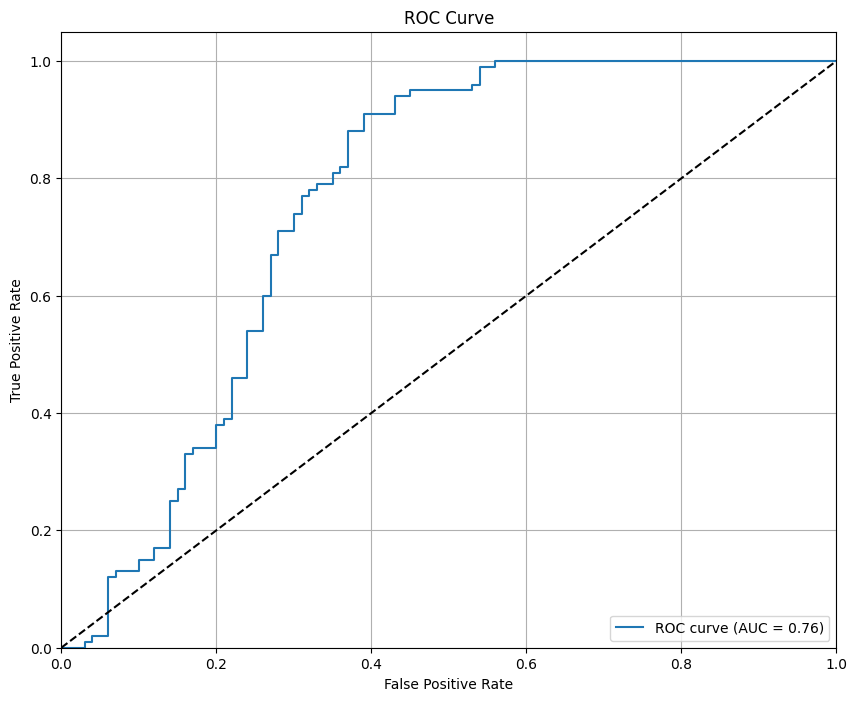

In [5]:
from networks.gradient_analysis import extract_gradients_by_layer

X, y = make_circles(n_samples=1000, factor=0.5, noise=0.1, random_state=42)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Convert to tensors
X_train = torch.FloatTensor(X_train)
X_test = torch.FloatTensor(X_test)
y_train = torch.FloatTensor(y_train)
y_test = torch.FloatTensor(y_test)

# Initialize model, loss, and optimizer
model = Perceptron(X_train.shape[1])
criterion = torch.nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Training loop
epochs = 50
losses = []

for epoch in range(epochs):
    # Forward pass
    outputs = model(X_train)

    # Calculate loss
    loss = criterion(outputs.squeeze(), y_train)
    losses.append(loss.item())

    # Zero gradients
    optimizer.zero_grad()

    # Backward pass (here the gradients are actually computed)
    loss.backward()

    extract_gradients_by_layer(model)

    # Update weights
    optimizer.step()

# Evaluation
model.eval()

with torch.no_grad():
    y_pred = model(X_test)
    y_pred_class = (y_pred.squeeze() > 0.5).float()
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred_class)
    f1 = f1_score(y_test, y_pred_class)
    
    # Calculate ROC curve and AUC
    fpr, tpr, _ = roc_curve(y_test.numpy(), y_pred.squeeze().numpy())
    roc_auc = auc(fpr, tpr)

    # Print classification report
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred_class))

    print(f'Accuracy: {accuracy:.4f}')
    print(f'F1 Score: {f1:.4f}')
    print(f'ROC AUC: {roc_auc:.4f}')

    # Plot ROC curve
    plt.figure(figsize=(10, 8))
    plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.show()

In [6]:
def compute_eigen_of_hessian(hessian):
    eigenvalues, _ = torch.linalg.eigh(hessian)
    return eigenvalues

In [7]:
def visualize_curvature(hessian):
    eigenvalues = compute_eigen_of_hessian(hessian)
    plt.plot(eigenvalues.detach().cpu().numpy())
    plt.title("Собственные значения Гессиана")
    plt.xlabel("Индекс")
    plt.ylabel("Собственное значение")
    plt.show()

In [8]:
from hessian.hessian import HessianCalculator

hc = HessianCalculator(model, criterion)

/home/maxim/git/net-arch-research/hessian/hessian.py:16: FutureWarning: We've integrated functorch into PyTorch. As the final step of the integration, `functorch.make_functional` is deprecated as of PyTorch 2.0 and will be deleted in a future version of PyTorch >= 2.3. Please use `torch.func.functional_call` instead; see the PyTorch 2.0 release notes and/or the `torch.func` migration guide for more details https://pytorch.org/docs/main/func.migrating.html
  self.fmodel, self.params = make_functional(model)


tensor([[ 3.5053e-04, -1.3616e-04,  1.5719e-04, -6.1061e-05, -1.0569e-03,
          4.1056e-04,  3.5667e-04, -1.3855e-04,  6.7927e-04, -2.6386e-04,
          1.2177e-03, -4.7303e-04,  6.6145e-04, -2.5694e-04,  1.0029e-03,
         -3.8958e-04,  4.0290e-04,  1.8068e-04, -1.2149e-03,  4.0997e-04,
          7.8077e-04,  1.3997e-03,  7.6029e-04,  1.1528e-03, -1.2065e-04,
         -3.0850e-05, -7.1565e-05, -1.5855e-04,  2.4766e-04,  2.9552e-06,
         -8.6113e-05,  1.4627e-04,  4.6322e-04,  1.1845e-04,  2.7477e-04,
          6.0875e-04, -9.5086e-04, -1.1346e-05,  3.3062e-04, -5.6159e-04,
          7.5554e-04,  1.9319e-04,  4.4816e-04,  9.9291e-04, -1.5509e-03,
         -1.8506e-05,  5.3926e-04, -9.1597e-04, -2.3214e-04, -5.9359e-05,
         -1.3770e-04, -3.0507e-04,  4.7651e-04,  5.6860e-06, -1.6569e-04,
          2.8143e-04,  6.9648e-04,  1.7809e-04,  4.1313e-04,  9.1530e-04,
         -1.4297e-03, -1.7060e-05,  4.9712e-04, -8.4438e-04, -3.7082e-04,
         -9.4821e-05, -2.1996e-04, -4.

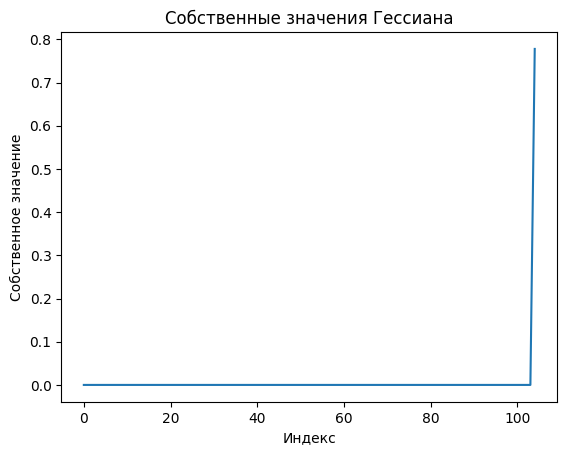

tensor([[ 3.8728e-05, -5.1170e-05,  1.2218e-04, -1.6143e-04,  3.0677e-04,
         -4.0533e-04,  3.1537e-04, -4.1668e-04, -3.7854e-04,  5.0015e-04,
         -1.1944e-04,  1.5781e-04,  2.8607e-04, -3.7797e-04, -2.3234e-04,
          3.0698e-04,  4.1078e-05,  1.2959e-04,  3.2539e-04,  3.3450e-04,
         -4.0151e-04, -1.2669e-04,  3.0343e-04, -2.4643e-04,  1.2718e-04,
         -4.3585e-05,  1.1346e-04,  3.0655e-06, -2.0681e-04, -1.1439e-04,
         -3.6010e-05, -3.1392e-04, -1.3336e-04,  4.5702e-05, -1.1897e-04,
         -3.2144e-06,  2.1686e-04,  1.1995e-04,  3.7758e-05,  3.2917e-04,
         -9.9121e-05,  3.3968e-05, -8.8423e-05, -2.3891e-06,  1.6118e-04,
          8.9152e-05,  2.8064e-05,  2.4465e-04,  6.7454e-05, -2.3116e-05,
          6.0174e-05,  1.6258e-06, -1.0969e-04, -6.0670e-05, -1.9098e-05,
         -1.6649e-04, -5.0207e-05,  1.7206e-05, -4.4789e-05, -1.2101e-06,
          8.1642e-05,  4.5158e-05,  1.4215e-05,  1.2392e-04,  1.0739e-04,
         -3.6801e-05,  9.5797e-05,  2.

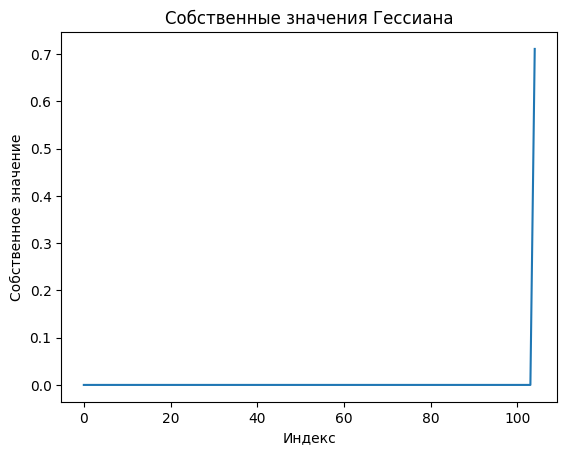

tensor([[ 6.4756e-04,  2.6688e-05,  1.4915e-03,  6.1470e-05,  1.6430e-03,
          6.7714e-05,  3.2382e-03,  1.3345e-04, -2.7375e-03, -1.1282e-04,
          3.9648e-04,  1.6340e-05,  3.5988e-03,  1.4832e-04, -1.1553e-03,
         -4.7612e-05, -3.4818e-04, -8.0197e-04, -8.8344e-04, -1.7411e-03,
          1.4719e-03, -2.1318e-04, -1.9350e-03,  6.2118e-04,  1.0380e-03,
          7.8251e-04, -1.6775e-03,  1.4469e-03, -7.2978e-06,  2.6758e-03,
          1.5574e-03,  1.8818e-03, -1.0119e-03, -7.6284e-04,  1.6354e-03,
         -1.4105e-03,  7.1143e-06, -2.6085e-03, -1.5182e-03, -1.8345e-03,
         -1.6713e-05, -1.2599e-05,  2.7010e-05, -2.3297e-05,  1.1750e-07,
         -4.3083e-05, -2.5075e-05, -3.0298e-05,  4.9288e-04,  3.7157e-04,
         -7.9657e-04,  6.8706e-04, -3.4653e-06,  1.2706e-03,  7.3950e-04,
          8.9355e-04, -5.1729e-06, -3.8997e-06,  8.3602e-06, -7.2108e-06,
          3.6369e-08, -1.3335e-05, -7.7612e-06, -9.3780e-06,  7.7290e-04,
          5.8267e-04, -1.2491e-03,  1.

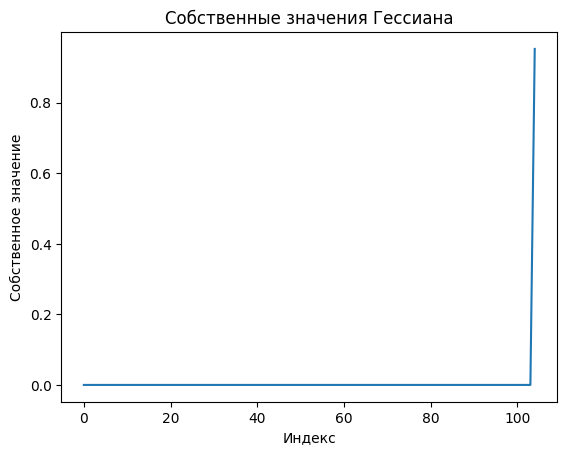

tensor([[ 3.2749e-04,  7.2184e-05,  8.6799e-04,  1.9132e-04,  9.2607e-04,
          2.0412e-04,  1.7981e-03,  3.9633e-04, -1.4957e-03, -3.2968e-04,
          2.4406e-04,  5.3793e-05,  2.0691e-03,  4.5606e-04, -6.5545e-04,
         -1.4447e-04, -1.9606e-04, -5.1963e-04, -5.5440e-04, -1.0765e-03,
          8.9542e-04, -1.4611e-04, -1.2387e-03,  3.9239e-04,  6.1294e-04,
          5.3634e-04, -1.0445e-03,  1.0060e-03, -3.6627e-05,  1.7047e-03,
          1.0430e-03,  1.2841e-03, -6.6210e-04, -5.7936e-04,  1.1283e-03,
         -1.0867e-03,  3.9565e-05, -1.8415e-03, -1.1266e-03, -1.3871e-03,
         -9.9020e-06, -8.6645e-06,  1.6874e-05, -1.6251e-05,  5.9171e-07,
         -2.7540e-05, -1.6849e-05, -2.0744e-05,  3.2361e-04,  2.8317e-04,
         -5.5148e-04,  5.3112e-04, -1.9338e-05,  9.0004e-04,  5.5065e-04,
          6.7794e-04, -2.8896e-06, -2.5285e-06,  4.9243e-06, -4.7425e-06,
          1.7267e-07, -8.0366e-06, -4.9169e-06, -6.0534e-06,  5.0698e-04,
          4.4363e-04, -8.6398e-04,  8.

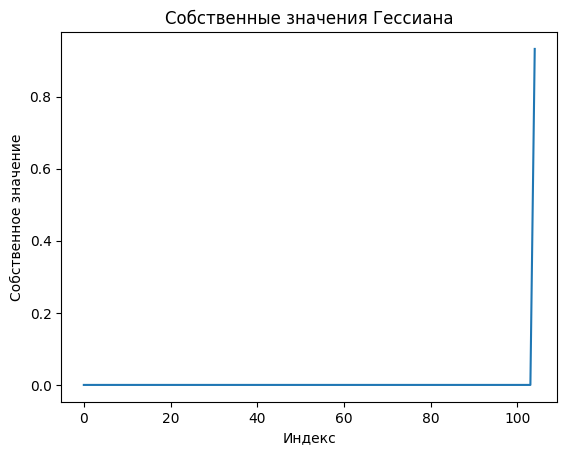

tensor([[ 1.8243e-05, -1.1037e-04,  9.6480e-06, -5.8368e-05, -4.7473e-05,
          2.8720e-04,  2.4278e-05, -1.4688e-04,  2.8408e-05, -1.7186e-04,
          5.8743e-05, -3.5538e-04,  3.8679e-05, -2.3400e-04,  4.7260e-05,
         -2.8591e-04, -1.1080e-04, -5.8598e-05,  2.8833e-04, -1.4745e-04,
         -1.7254e-04, -3.5678e-04, -2.3492e-04, -2.8704e-04,  6.8359e-06,
          1.0859e-05,  1.9440e-05,  3.8737e-05, -4.4943e-05, -5.9022e-06,
          2.0498e-05, -9.2976e-06, -3.6925e-05, -5.8658e-05, -1.0501e-04,
         -2.0924e-04,  2.4276e-04,  3.1881e-05, -1.1072e-04,  5.0222e-05,
         -6.0373e-05, -9.5907e-05, -1.7169e-04, -3.4211e-04,  3.9692e-04,
          5.2127e-05, -1.8103e-04,  8.2114e-05,  1.8041e-05,  2.8660e-05,
          5.1305e-05,  1.0223e-04, -1.1861e-04, -1.5577e-05,  5.4098e-05,
         -2.4538e-05, -6.4453e-05, -1.0239e-04, -1.8329e-04, -3.6523e-04,
          4.2374e-04,  5.5649e-05, -1.9327e-04,  8.7663e-05,  2.8943e-05,
          4.5978e-05,  8.2308e-05,  1.

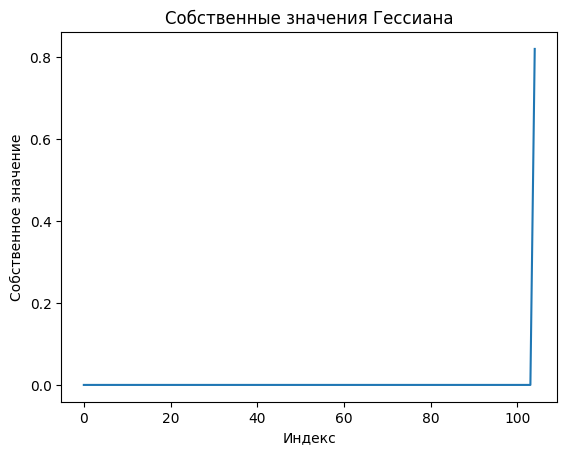

tensor([[ 5.6869e-06,  3.2578e-06,  7.2916e-05,  4.1770e-05,  6.7744e-05,
          3.8808e-05,  1.1915e-04,  6.8257e-05, -8.8065e-05, -5.0449e-05,
          2.6058e-05,  1.4927e-05,  1.6730e-04,  9.5841e-05, -4.9386e-05,
         -2.8291e-05, -3.7546e-06, -4.8140e-05, -4.4725e-05, -7.8665e-05,
          5.8142e-05, -1.7204e-05, -1.1046e-04,  3.2605e-05,  4.8699e-05,
          5.2259e-05, -8.5566e-05,  1.0186e-04, -1.2533e-05,  1.4740e-04,
          9.8984e-05,  1.2000e-04, -8.4391e-05, -9.0560e-05,  1.4828e-04,
         -1.7651e-04,  2.1719e-05, -2.5544e-04, -1.7153e-04, -2.0795e-04,
         -7.3833e-07, -7.9230e-07,  1.2973e-06, -1.5443e-06,  1.9001e-07,
         -2.2348e-06, -1.5007e-06, -1.8193e-06,  4.1436e-05,  4.4466e-05,
         -7.2806e-05,  8.6669e-05, -1.0664e-05,  1.2542e-04,  8.4223e-05,
          1.0211e-04, -1.8579e-07, -1.9937e-07,  3.2645e-07, -3.8861e-07,
          4.7815e-08, -5.6237e-07, -3.7764e-07, -4.5782e-07,  6.4634e-05,
          6.9359e-05, -1.1357e-04,  1.

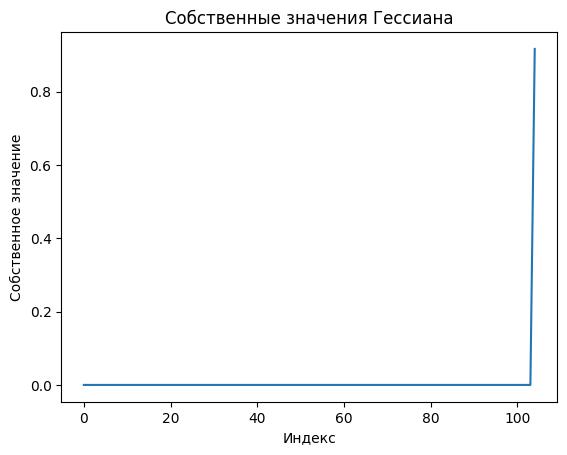

In [9]:
for i in range(len(X_train)):
    output = model(X_train[i])
    hessian = hc.hessian_wrt_params(X_train[i], output)
    print(hessian)
    print(compute_eigen_of_hessian(hessian))
    visualize_curvature(hessian)

    if i == 5:
        break

# ПО ВХОДУ

tensor([[0.0385, 0.0308],
        [0.0308, 0.0246]])
tensor([9.3132e-10, 6.3053e-02])


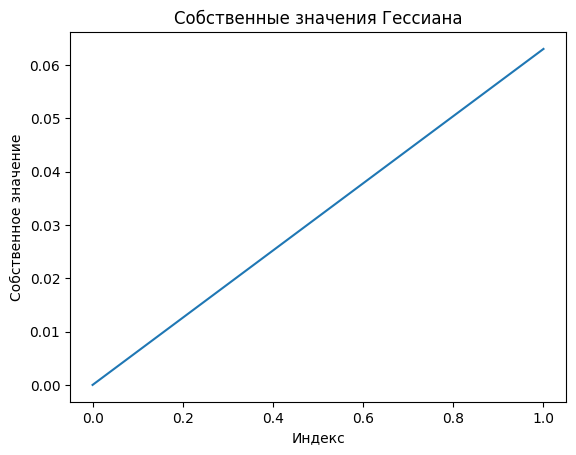

tensor([[0.0070, 0.0081],
        [0.0081, 0.0094]])
tensor([9.3132e-10, 1.6414e-02])


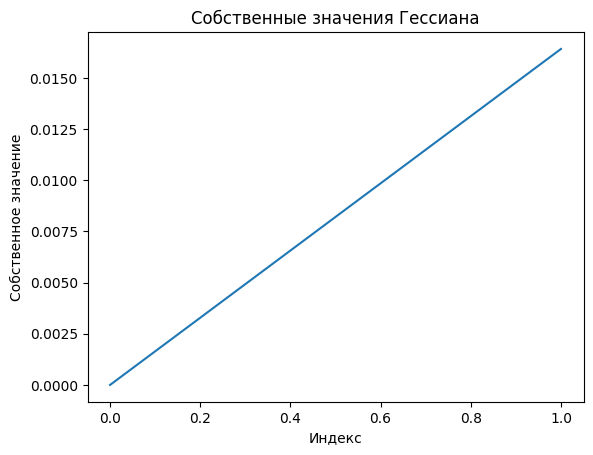

tensor([[0.0310, 0.0308],
        [0.0308, 0.0306]])
tensor([-5.5879e-09,  6.1589e-02])


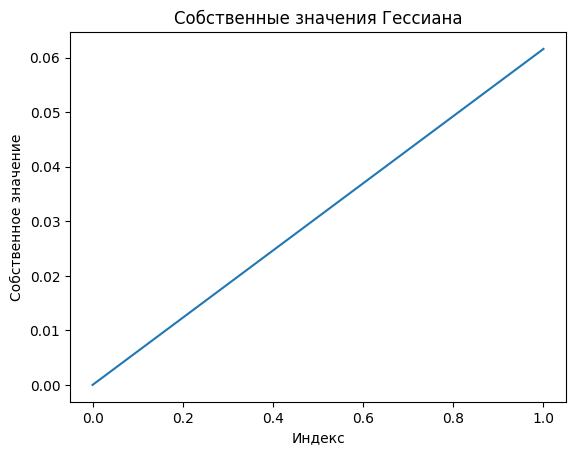

tensor([[0.0240, 0.0239],
        [0.0239, 0.0238]])
tensor([1.8626e-09, 4.7747e-02])


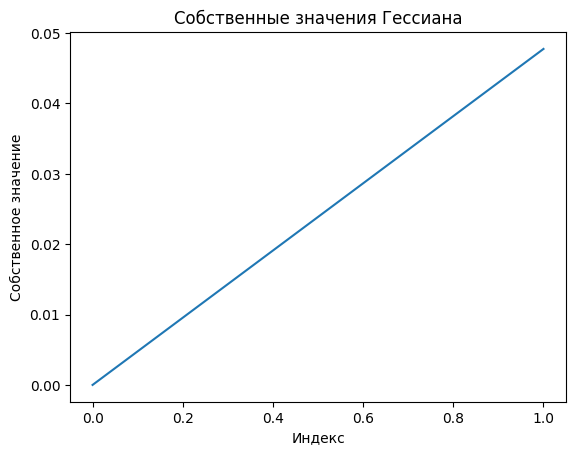

tensor([[0.0581, 0.0478],
        [0.0478, 0.0392]])
tensor([-1.8626e-09,  9.7372e-02])


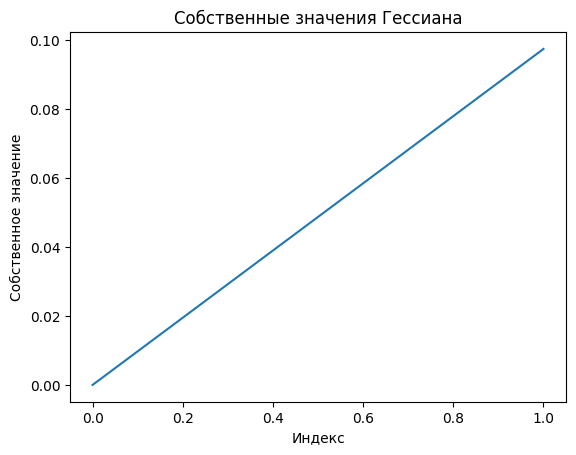

tensor([[0.0084, 0.0085],
        [0.0085, 0.0086]])
tensor([4.6566e-10, 1.6909e-02])


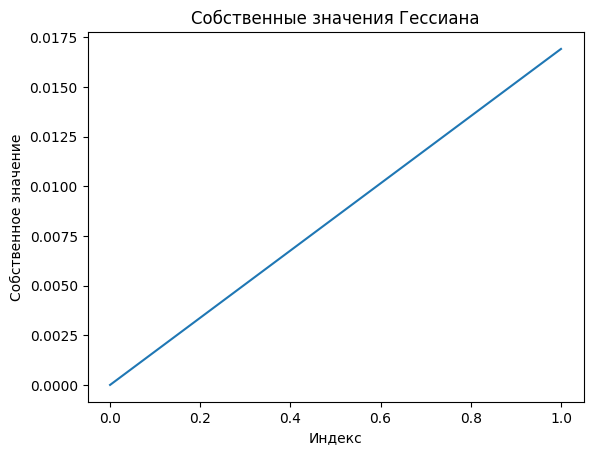

In [10]:
for i in range(len(X_train)):
    output = model(X_train[i])
    hessian = hc.hessian_wrt_inputs(X_train[i], output)
    print(hessian)
    print(compute_eigen_of_hessian(hessian))
    visualize_curvature(hessian)

    if i == 5:
        break

# ПО СЛОЯМ - ПАРАМЕТРЫ

In [11]:
from hessian.layer_wise_hessian import compute_local_hessians_for_chunks

hess = compute_local_hessians_for_chunks(model, X_train[0])

for name, i in hess.items():
    print(f"Chunk idx {name} and hessian of layer chunk {i}")
    print(f"Eigenvalue of {name}'th hessian {compute_eigen_of_hessian(i)}")
    print("=" * 80)

Chunk idx 0 and hessian of layer chunk tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       

# Веса сети

In [12]:
for name, param in model.named_parameters():
    print(f"{name}:")
    print(param.data)
    print("="*50)

layer.weight:
tensor([[-0.6924, -0.1692],
        [-0.4204, -0.4854],
        [ 0.5081,  0.1844],
        [-1.0302, -1.1431],
        [ 0.6184,  0.5842],
        [-1.1009, -0.7034],
        [-0.8820, -0.8559],
        [-0.4764, -0.7873]])
layer.bias:
tensor([-0.1991,  0.0114, -0.8212, -0.4681,  1.1871,  0.7383, -0.0531,  1.0507])
layer2.weight:
tensor([[-0.5880, -0.3441, -0.2389, -0.7842,  0.8207,  0.0292, -0.4835,  0.1913],
        [-0.2867,  0.0422,  0.1059, -0.1858,  0.2877,  0.2155,  0.2985, -0.0239],
        [-0.0973, -0.2831,  0.4873, -0.2394, -0.0835, -0.7693, -0.6223, -0.2587],
        [-0.0507,  0.0548, -0.0175,  0.1645, -0.2048,  0.0443, -0.2152, -0.1287],
        [-0.2044, -0.1478,  0.5808, -0.4305, -0.6428, -0.7887, -0.7112, -0.8027],
        [ 0.1548, -0.2269,  0.1478, -0.0130, -0.0669,  0.0373,  0.1074,  0.0913],
        [ 0.1182,  0.2172,  0.3847,  0.6230, -0.6357,  0.2702,  0.7982, -0.2331],
        [ 0.0769,  0.1848,  0.4320,  0.9060, -0.7438, -0.0663,  0.7431, -0.2753

=== Спектральный анализ: Layer 0 ===
Минимальное собственное значение: 0.000000
Максимальное собственное значение: 0.000000
Среднее собственное значение: 0.000000
Стандартное отклонение: 0.000000
Число отрицательных значений: 0
Число положительных значений: 0


/home/maxim/git/net-arch-research/hessian/hessian_analysis.py:80: SyntaxWarning: invalid escape sequence '\k'
  """


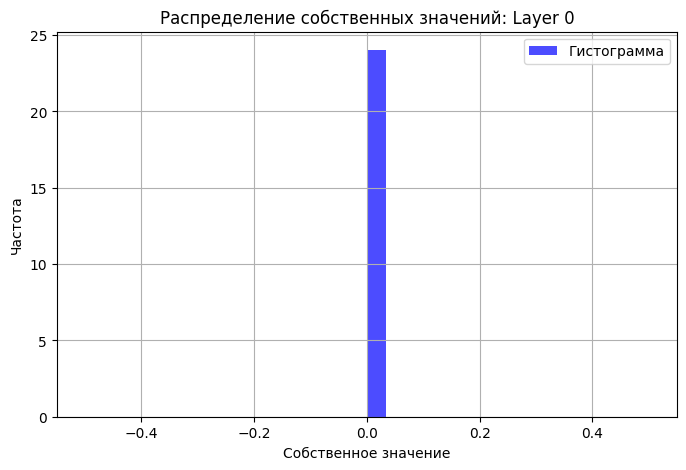

[Предупреждение] KDE не может быть построена для слоя 'Layer 0': The data appears to lie in a lower-dimensional subspace of the space in which it is expressed. This has resulted in a singular data covariance matrix, which cannot be treated using the algorithms implemented in `gaussian_kde`. Consider performing principal component analysis / dimensionality reduction and using `gaussian_kde` with the transformed data.
=== Спектральный анализ: Layer 1 ===
Минимальное собственное значение: -0.494026
Максимальное собственное значение: 0.593803
Среднее собственное значение: 0.021769
Стандартное отклонение: 0.127339
Число отрицательных значений: 36
Число положительных значений: 36


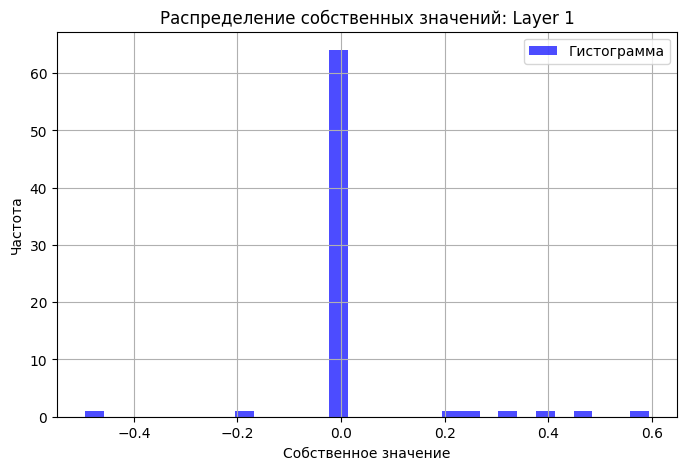

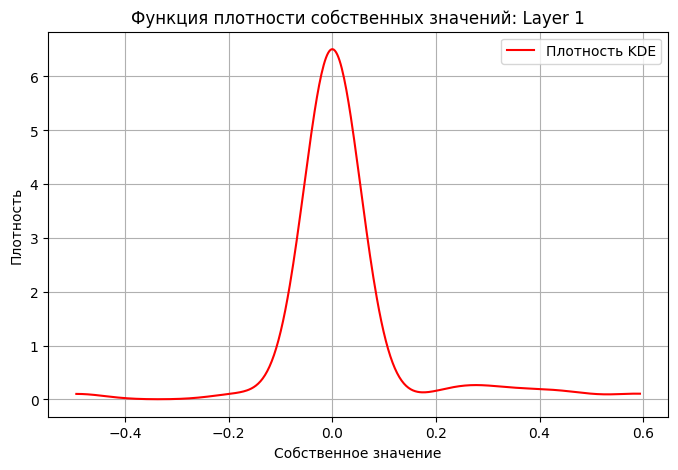

=== Спектральный анализ: Layer 2 ===
Минимальное собственное значение: -0.110888
Максимальное собственное значение: 0.000000
Среднее собственное значение: -0.012321
Стандартное отклонение: 0.034849
Число отрицательных значений: 4
Число положительных значений: 5


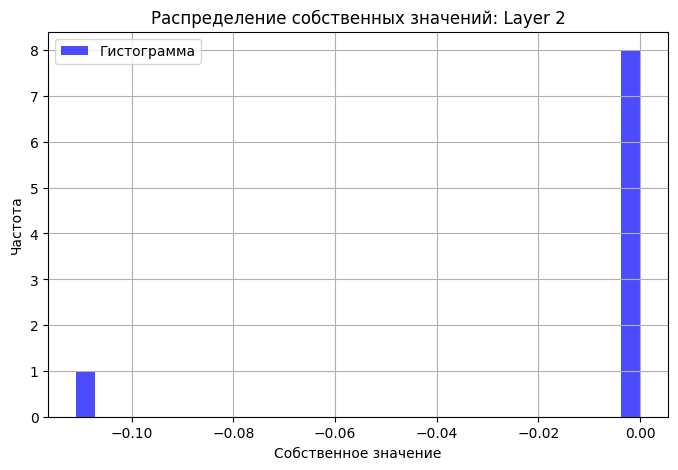

In [13]:
from hessian.hessian_analysis import spectral_analysis, compute_condition_number

hess_list = list(hess.values())

spectral_analysis(hess_list, None)

In [14]:
compute_condition_number(hess_list)

=== Число обусловленности для Layer 0 ===
λ_min: 0.000000, λ_max: 0.000000, κ: inf
=== Число обусловленности для Layer 1 ===
λ_min: -0.494026, λ_max: 0.593803, κ: -1.2019672393798828
=== Число обусловленности для Layer 2 ===
λ_min: -0.110888, λ_max: 0.000000, κ: -1.3122061659487372e-08


{'Layer 0': inf,
 'Layer 1': np.float32(-1.2019672),
 'Layer 2': np.float32(-1.3122062e-08)}